# Setup Imports


Code from: https://arena-ch1-transformers.streamlit.app/[1.3]_Indirect_Object_Identification

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping
    %pip install transformer_lens
    %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python

    # Code to download the necessary files (e.g. solutions, test funcs)
    import os, sys
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")
        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import os; os.environ["ACCELERATE_DISABLE_RICH"] = "1"
import sys
from pathlib import Path
import torch as t
from torch import Tensor
import numpy as np
import einops
from tqdm.notebook import tqdm
import plotly.express as px
import webbrowser
import re
import itertools
from jaxtyping import Float, Int, Bool
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set
from functools import partial
from IPython.display import display, HTML
from rich.table import Table, Column
from rich import print as rprint
import circuitsvis as cv
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, ActivationCache
from transformer_lens.components import Embed, Unembed, LayerNorm, MLP

t.set_grad_enabled(False)

# Make sure exercises are in the path
chapter = r"chapter1_transformers"
exercises_dir = Path(f"{os.getcwd().split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = (exercises_dir / "part3_indirect_object_identification").resolve()
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

from plotly_utils import imshow, line, scatter, bar
import part3_indirect_object_identification.tests as tests

device = t.device("cuda") if t.cuda.is_available() else t.device("cpu")

MAIN = __name__ == "__main__"

/usr/local/lib/python3.10/dist-packages/accelerate/utils/imports.py:197: UserWarning: `ACCELERATE_DISABLE_RICH` is deprecated and will be removed in v0.22.0 and deactivated by default. Please use `ACCELERATE_ENABLE_RICH` if you wish to use `rich`.
  warnings.warn(


In [3]:
from part3_indirect_object_identification.ioi_dataset import NAMES, IOIDataset

## Load Model, Data, and Functions

In [4]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


# Generate dataset with multiple prompts

In [5]:
import torch  # before used 'import torch as t'

In [6]:
class Dataset:
    def __init__(self, prompts, pos_dict, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.io_tokenIDs = [
            self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
        ]
        self.s_tokenIDs = [
            self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                # if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                #     target_token = prompt[targ]
                # else:
                #     target_token = "Ġ" + prompt[targ]
                # target_index = tokens.index(target_token)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [7]:
pos_dict = {
    'S1': 0,
    'S2': 1,
    'S3': 2,
    'S4': 3,
    'S5': 4,
    'S6': 5,
    'S7': 6,
    'S8': 7,
}

In [8]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y, -1):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i-1),
            'S3': str(i-2),
            'S4': str(i-3),
            'S5': str(i-4),
            'S6': str(i-5),
            'S7': str(i-6),
            'S8': str(i-7),
            'corr': str(i-8),
            'incorr': str(i-7),
            'text': f"{i} {i-1} {i-2} {i-3} {i-4} {i-5} {i-6} {i-7}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(100, 8)
dataset = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)
len(prompts_list)

92

In [9]:
prompts_list_2 = [{'S1': '53',
  'S2': '8',
  'S3': '58',
  'S4': '57',
  'S5': '2',
  'S6': '4',
  'S7': '72',
  'S8': '57',
  'corr': '92',
  'incorr': '93',
  'text': '53 8 58 57 2 4 72 57'},
 {'S1': '93',
  'S2': '43',
  'S3': '43',
  'S4': '31',
  'S5': '3',
  'S6': '16',
  'S7': '59',
  'S8': '37',
  'corr': '91',
  'incorr': '92',
  'text': '93 43 43 31 3 16 59 37'},
 {'S1': '97',
  'S2': '55',
  'S3': '37',
  'S4': '63',
  'S5': '89',
  'S6': '47',
  'S7': '33',
  'S8': '82',
  'corr': '90',
  'incorr': '91',
  'text': '97 55 37 63 89 47 33 82'},
 {'S1': '14',
  'S2': '4',
  'S3': '59',
  'S4': '81',
  'S5': '70',
  'S6': '80',
  'S7': '10',
  'S8': '57',
  'corr': '89',
  'incorr': '90',
  'text': '14 4 59 81 70 80 10 57'},
 {'S1': '30',
  'S2': '80',
  'S3': '92',
  'S4': '16',
  'S5': '99',
  'S6': '15',
  'S7': '57',
  'S8': '17',
  'corr': '88',
  'incorr': '89',
  'text': '30 80 92 16 99 15 57 17'},
 {'S1': '80',
  'S2': '91',
  'S3': '90',
  'S4': '96',
  'S5': '50',
  'S6': '79',
  'S7': '70',
  'S8': '16',
  'corr': '87',
  'incorr': '88',
  'text': '80 91 90 96 50 79 70 16'},
 {'S1': '51',
  'S2': '75',
  'S3': '98',
  'S4': '96',
  'S5': '77',
  'S6': '97',
  'S7': '13',
  'S8': '23',
  'corr': '86',
  'incorr': '87',
  'text': '51 75 98 96 77 97 13 23'},
 {'S1': '31',
  'S2': '38',
  'S3': '96',
  'S4': '42',
  'S5': '8',
  'S6': '10',
  'S7': '69',
  'S8': '59',
  'corr': '85',
  'incorr': '86',
  'text': '31 38 96 42 8 10 69 59'},
 {'S1': '14',
  'S2': '15',
  'S3': '88',
  'S4': '76',
  'S5': '58',
  'S6': '56',
  'S7': '84',
  'S8': '53',
  'corr': '84',
  'incorr': '85',
  'text': '14 15 88 76 58 56 84 53'},
 {'S1': '4',
  'S2': '24',
  'S3': '96',
  'S4': '65',
  'S5': '38',
  'S6': '18',
  'S7': '91',
  'S8': '31',
  'corr': '83',
  'incorr': '84',
  'text': '4 24 96 65 38 18 91 31'},
 {'S1': '73',
  'S2': '77',
  'S3': '76',
  'S4': '53',
  'S5': '32',
  'S6': '44',
  'S7': '43',
  'S8': '11',
  'corr': '82',
  'incorr': '83',
  'text': '73 77 76 53 32 44 43 11'},
 {'S1': '83',
  'S2': '100',
  'S3': '99',
  'S4': '54',
  'S5': '94',
  'S6': '76',
  'S7': '11',
  'S8': '47',
  'corr': '81',
  'incorr': '82',
  'text': '83 100 99 54 94 76 11 47'},
 {'S1': '46',
  'S2': '23',
  'S3': '35',
  'S4': '51',
  'S5': '90',
  'S6': '25',
  'S7': '29',
  'S8': '12',
  'corr': '80',
  'incorr': '81',
  'text': '46 23 35 51 90 25 29 12'},
 {'S1': '39',
  'S2': '28',
  'S3': '28',
  'S4': '47',
  'S5': '14',
  'S6': '29',
  'S7': '44',
  'S8': '12',
  'corr': '79',
  'incorr': '80',
  'text': '39 28 28 47 14 29 44 12'},
 {'S1': '22',
  'S2': '36',
  'S3': '31',
  'S4': '56',
  'S5': '56',
  'S6': '7',
  'S7': '53',
  'S8': '62',
  'corr': '78',
  'incorr': '79',
  'text': '22 36 31 56 56 7 53 62'},
 {'S1': '84',
  'S2': '10',
  'S3': '56',
  'S4': '64',
  'S5': '9',
  'S6': '79',
  'S7': '63',
  'S8': '70',
  'corr': '77',
  'incorr': '78',
  'text': '84 10 56 64 9 79 63 70'},
 {'S1': '88',
  'S2': '72',
  'S3': '11',
  'S4': '15',
  'S5': '64',
  'S6': '60',
  'S7': '74',
  'S8': '90',
  'corr': '76',
  'incorr': '77',
  'text': '88 72 11 15 64 60 74 90'},
 {'S1': '32',
  'S2': '80',
  'S3': '51',
  'S4': '40',
  'S5': '41',
  'S6': '9',
  'S7': '25',
  'S8': '34',
  'corr': '75',
  'incorr': '76',
  'text': '32 80 51 40 41 9 25 34'},
 {'S1': '97',
  'S2': '26',
  'S3': '15',
  'S4': '81',
  'S5': '89',
  'S6': '92',
  'S7': '26',
  'S8': '59',
  'corr': '74',
  'incorr': '75',
  'text': '97 26 15 81 89 92 26 59'},
 {'S1': '9',
  'S2': '39',
  'S3': '37',
  'S4': '52',
  'S5': '53',
  'S6': '6',
  'S7': '18',
  'S8': '75',
  'corr': '73',
  'incorr': '74',
  'text': '9 39 37 52 53 6 18 75'},
 {'S1': '68',
  'S2': '60',
  'S3': '98',
  'S4': '43',
  'S5': '80',
  'S6': '83',
  'S7': '33',
  'S8': '35',
  'corr': '72',
  'incorr': '73',
  'text': '68 60 98 43 80 83 33 35'},
 {'S1': '98',
  'S2': '37',
  'S3': '27',
  'S4': '64',
  'S5': '64',
  'S6': '89',
  'S7': '26',
  'S8': '46',
  'corr': '71',
  'incorr': '72',
  'text': '98 37 27 64 64 89 26 46'},
 {'S1': '25',
  'S2': '17',
  'S3': '70',
  'S4': '51',
  'S5': '86',
  'S6': '83',
  'S7': '75',
  'S8': '16',
  'corr': '70',
  'incorr': '71',
  'text': '25 17 70 51 86 83 75 16'},
 {'S1': '98',
  'S2': '31',
  'S3': '62',
  'S4': '40',
  'S5': '76',
  'S6': '70',
  'S7': '80',
  'S8': '71',
  'corr': '69',
  'incorr': '70',
  'text': '98 31 62 40 76 70 80 71'},
 {'S1': '5',
  'S2': '82',
  'S3': '10',
  'S4': '69',
  'S5': '8',
  'S6': '69',
  'S7': '23',
  'S8': '2',
  'corr': '68',
  'incorr': '69',
  'text': '5 82 10 69 8 69 23 2'},
 {'S1': '65',
  'S2': '67',
  'S3': '70',
  'S4': '96',
  'S5': '51',
  'S6': '94',
  'S7': '9',
  'S8': '83',
  'corr': '67',
  'incorr': '68',
  'text': '65 67 70 96 51 94 9 83'},
 {'S1': '63',
  'S2': '24',
  'S3': '9',
  'S4': '44',
  'S5': '44',
  'S6': '93',
  'S7': '71',
  'S8': '100',
  'corr': '66',
  'incorr': '67',
  'text': '63 24 9 44 44 93 71 100'},
 {'S1': '100',
  'S2': '64',
  'S3': '48',
  'S4': '22',
  'S5': '46',
  'S6': '20',
  'S7': '72',
  'S8': '11',
  'corr': '65',
  'incorr': '66',
  'text': '100 64 48 22 46 20 72 11'},
 {'S1': '81',
  'S2': '3',
  'S3': '49',
  'S4': '55',
  'S5': '96',
  'S6': '50',
  'S7': '14',
  'S8': '5',
  'corr': '64',
  'incorr': '65',
  'text': '81 3 49 55 96 50 14 5'},
 {'S1': '12',
  'S2': '23',
  'S3': '29',
  'S4': '18',
  'S5': '29',
  'S6': '3',
  'S7': '14',
  'S8': '20',
  'corr': '63',
  'incorr': '64',
  'text': '12 23 29 18 29 3 14 20'},
 {'S1': '87',
  'S2': '54',
  'S3': '51',
  'S4': '81',
  'S5': '64',
  'S6': '37',
  'S7': '33',
  'S8': '53',
  'corr': '62',
  'incorr': '63',
  'text': '87 54 51 81 64 37 33 53'},
 {'S1': '12',
  'S2': '7',
  'S3': '70',
  'S4': '54',
  'S5': '15',
  'S6': '20',
  'S7': '30',
  'S8': '63',
  'corr': '61',
  'incorr': '62',
  'text': '12 7 70 54 15 20 30 63'},
 {'S1': '31',
  'S2': '28',
  'S3': '29',
  'S4': '98',
  'S5': '80',
  'S6': '21',
  'S7': '16',
  'S8': '94',
  'corr': '60',
  'incorr': '61',
  'text': '31 28 29 98 80 21 16 94'},
 {'S1': '67',
  'S2': '25',
  'S3': '94',
  'S4': '52',
  'S5': '38',
  'S6': '45',
  'S7': '99',
  'S8': '72',
  'corr': '59',
  'incorr': '60',
  'text': '67 25 94 52 38 45 99 72'},
 {'S1': '89',
  'S2': '41',
  'S3': '41',
  'S4': '62',
  'S5': '11',
  'S6': '50',
  'S7': '50',
  'S8': '78',
  'corr': '58',
  'incorr': '59',
  'text': '89 41 41 62 11 50 50 78'},
 {'S1': '94',
  'S2': '64',
  'S3': '34',
  'S4': '3',
  'S5': '78',
  'S6': '78',
  'S7': '22',
  'S8': '34',
  'corr': '57',
  'incorr': '58',
  'text': '94 64 34 3 78 78 22 34'},
 {'S1': '100',
  'S2': '32',
  'S3': '24',
  'S4': '54',
  'S5': '3',
  'S6': '18',
  'S7': '80',
  'S8': '72',
  'corr': '56',
  'incorr': '57',
  'text': '100 32 24 54 3 18 80 72'},
 {'S1': '77',
  'S2': '94',
  'S3': '54',
  'S4': '57',
  'S5': '63',
  'S6': '30',
  'S7': '34',
  'S8': '56',
  'corr': '55',
  'incorr': '56',
  'text': '77 94 54 57 63 30 34 56'},
 {'S1': '62',
  'S2': '33',
  'S3': '86',
  'S4': '83',
  'S5': '84',
  'S6': '28',
  'S7': '57',
  'S8': '39',
  'corr': '54',
  'incorr': '55',
  'text': '62 33 86 83 84 28 57 39'},
 {'S1': '40',
  'S2': '42',
  'S3': '11',
  'S4': '59',
  'S5': '48',
  'S6': '24',
  'S7': '6',
  'S8': '82',
  'corr': '53',
  'incorr': '54',
  'text': '40 42 11 59 48 24 6 82'},
 {'S1': '53',
  'S2': '88',
  'S3': '61',
  'S4': '88',
  'S5': '88',
  'S6': '90',
  'S7': '70',
  'S8': '73',
  'corr': '52',
  'incorr': '53',
  'text': '53 88 61 88 88 90 70 73'},
 {'S1': '22',
  'S2': '42',
  'S3': '11',
  'S4': '21',
  'S5': '36',
  'S6': '71',
  'S7': '33',
  'S8': '6',
  'corr': '51',
  'incorr': '52',
  'text': '22 42 11 21 36 71 33 6'},
 {'S1': '47',
  'S2': '43',
  'S3': '76',
  'S4': '57',
  'S5': '25',
  'S6': '37',
  'S7': '12',
  'S8': '59',
  'corr': '50',
  'incorr': '51',
  'text': '47 43 76 57 25 37 12 59'},
 {'S1': '13',
  'S2': '69',
  'S3': '42',
  'S4': '28',
  'S5': '24',
  'S6': '17',
  'S7': '100',
  'S8': '52',
  'corr': '49',
  'incorr': '50',
  'text': '13 69 42 28 24 17 100 52'},
 {'S1': '72',
  'S2': '21',
  'S3': '83',
  'S4': '17',
  'S5': '81',
  'S6': '50',
  'S7': '55',
  'S8': '77',
  'corr': '48',
  'incorr': '49',
  'text': '72 21 83 17 81 50 55 77'},
 {'S1': '91',
  'S2': '91',
  'S3': '42',
  'S4': '24',
  'S5': '31',
  'S6': '74',
  'S7': '2',
  'S8': '5',
  'corr': '47',
  'incorr': '48',
  'text': '91 91 42 24 31 74 2 5'},
 {'S1': '75',
  'S2': '49',
  'S3': '6',
  'S4': '3',
  'S5': '45',
  'S6': '59',
  'S7': '16',
  'S8': '21',
  'corr': '46',
  'incorr': '47',
  'text': '75 49 6 3 45 59 16 21'},
 {'S1': '31',
  'S2': '75',
  'S3': '68',
  'S4': '24',
  'S5': '80',
  'S6': '30',
  'S7': '91',
  'S8': '97',
  'corr': '45',
  'incorr': '46',
  'text': '31 75 68 24 80 30 91 97'},
 {'S1': '78',
  'S2': '89',
  'S3': '96',
  'S4': '32',
  'S5': '33',
  'S6': '80',
  'S7': '67',
  'S8': '72',
  'corr': '44',
  'incorr': '45',
  'text': '78 89 96 32 33 80 67 72'},
 {'S1': '78',
  'S2': '31',
  'S3': '94',
  'S4': '53',
  'S5': '59',
  'S6': '31',
  'S7': '17',
  'S8': '37',
  'corr': '43',
  'incorr': '44',
  'text': '78 31 94 53 59 31 17 37'},
 {'S1': '9',
  'S2': '49',
  'S3': '67',
  'S4': '59',
  'S5': '45',
  'S6': '69',
  'S7': '2',
  'S8': '86',
  'corr': '42',
  'incorr': '43',
  'text': '9 49 67 59 45 69 2 86'},
 {'S1': '73',
  'S2': '28',
  'S3': '15',
  'S4': '36',
  'S5': '34',
  'S6': '83',
  'S7': '23',
  'S8': '52',
  'corr': '41',
  'incorr': '42',
  'text': '73 28 15 36 34 83 23 52'},
 {'S1': '33',
  'S2': '28',
  'S3': '37',
  'S4': '19',
  'S5': '95',
  'S6': '50',
  'S7': '16',
  'S8': '55',
  'corr': '40',
  'incorr': '41',
  'text': '33 28 37 19 95 50 16 55'},
 {'S1': '21',
  'S2': '19',
  'S3': '46',
  'S4': '8',
  'S5': '91',
  'S6': '22',
  'S7': '58',
  'S8': '24',
  'corr': '39',
  'incorr': '40',
  'text': '21 19 46 8 91 22 58 24'},
 {'S1': '67',
  'S2': '41',
  'S3': '34',
  'S4': '74',
  'S5': '68',
  'S6': '4',
  'S7': '14',
  'S8': '77',
  'corr': '38',
  'incorr': '39',
  'text': '67 41 34 74 68 4 14 77'},
 {'S1': '63',
  'S2': '23',
  'S3': '16',
  'S4': '18',
  'S5': '70',
  'S6': '84',
  'S7': '76',
  'S8': '6',
  'corr': '37',
  'incorr': '38',
  'text': '63 23 16 18 70 84 76 6'},
 {'S1': '21',
  'S2': '13',
  'S3': '67',
  'S4': '36',
  'S5': '90',
  'S6': '43',
  'S7': '75',
  'S8': '69',
  'corr': '36',
  'incorr': '37',
  'text': '21 13 67 36 90 43 75 69'},
 {'S1': '23',
  'S2': '40',
  'S3': '54',
  'S4': '55',
  'S5': '39',
  'S6': '53',
  'S7': '85',
  'S8': '93',
  'corr': '35',
  'incorr': '36',
  'text': '23 40 54 55 39 53 85 93'},
 {'S1': '69',
  'S2': '84',
  'S3': '24',
  'S4': '20',
  'S5': '99',
  'S6': '22',
  'S7': '97',
  'S8': '12',
  'corr': '34',
  'incorr': '35',
  'text': '69 84 24 20 99 22 97 12'},
 {'S1': '42',
  'S2': '61',
  'S3': '88',
  'S4': '41',
  'S5': '90',
  'S6': '11',
  'S7': '54',
  'S8': '19',
  'corr': '33',
  'incorr': '34',
  'text': '42 61 88 41 90 11 54 19'},
 {'S1': '73',
  'S2': '29',
  'S3': '86',
  'S4': '8',
  'S5': '5',
  'S6': '51',
  'S7': '25',
  'S8': '91',
  'corr': '32',
  'incorr': '33',
  'text': '73 29 86 8 5 51 25 91'},
 {'S1': '16',
  'S2': '26',
  'S3': '34',
  'S4': '58',
  'S5': '68',
  'S6': '88',
  'S7': '61',
  'S8': '55',
  'corr': '31',
  'incorr': '32',
  'text': '16 26 34 58 68 88 61 55'},
 {'S1': '33',
  'S2': '9',
  'S3': '79',
  'S4': '11',
  'S5': '7',
  'S6': '53',
  'S7': '39',
  'S8': '23',
  'corr': '30',
  'incorr': '31',
  'text': '33 9 79 11 7 53 39 23'},
 {'S1': '38',
  'S2': '76',
  'S3': '79',
  'S4': '21',
  'S5': '94',
  'S6': '100',
  'S7': '21',
  'S8': '59',
  'corr': '29',
  'incorr': '30',
  'text': '38 76 79 21 94 100 21 59'},
 {'S1': '6',
  'S2': '66',
  'S3': '41',
  'S4': '38',
  'S5': '77',
  'S6': '52',
  'S7': '11',
  'S8': '11',
  'corr': '28',
  'incorr': '29',
  'text': '6 66 41 38 77 52 11 11'},
 {'S1': '26',
  'S2': '25',
  'S3': '63',
  'S4': '70',
  'S5': '13',
  'S6': '98',
  'S7': '39',
  'S8': '49',
  'corr': '27',
  'incorr': '28',
  'text': '26 25 63 70 13 98 39 49'},
 {'S1': '90',
  'S2': '43',
  'S3': '53',
  'S4': '10',
  'S5': '40',
  'S6': '85',
  'S7': '90',
  'S8': '4',
  'corr': '26',
  'incorr': '27',
  'text': '90 43 53 10 40 85 90 4'},
 {'S1': '16',
  'S2': '74',
  'S3': '20',
  'S4': '47',
  'S5': '11',
  'S6': '86',
  'S7': '78',
  'S8': '64',
  'corr': '25',
  'incorr': '26',
  'text': '16 74 20 47 11 86 78 64'},
 {'S1': '25',
  'S2': '20',
  'S3': '29',
  'S4': '35',
  'S5': '76',
  'S6': '82',
  'S7': '36',
  'S8': '77',
  'corr': '24',
  'incorr': '25',
  'text': '25 20 29 35 76 82 36 77'},
 {'S1': '4',
  'S2': '78',
  'S3': '97',
  'S4': '23',
  'S5': '3',
  'S6': '89',
  'S7': '65',
  'S8': '53',
  'corr': '23',
  'incorr': '24',
  'text': '4 78 97 23 3 89 65 53'},
 {'S1': '77',
  'S2': '98',
  'S3': '49',
  'S4': '59',
  'S5': '30',
  'S6': '44',
  'S7': '60',
  'S8': '36',
  'corr': '22',
  'incorr': '23',
  'text': '77 98 49 59 30 44 60 36'},
 {'S1': '44',
  'S2': '74',
  'S3': '6',
  'S4': '91',
  'S5': '6',
  'S6': '54',
  'S7': '94',
  'S8': '66',
  'corr': '21',
  'incorr': '22',
  'text': '44 74 6 91 6 54 94 66'},
 {'S1': '66',
  'S2': '42',
  'S3': '72',
  'S4': '38',
  'S5': '65',
  'S6': '47',
  'S7': '63',
  'S8': '16',
  'corr': '20',
  'incorr': '21',
  'text': '66 42 72 38 65 47 63 16'},
 {'S1': '66',
  'S2': '97',
  'S3': '46',
  'S4': '77',
  'S5': '40',
  'S6': '6',
  'S7': '81',
  'S8': '46',
  'corr': '19',
  'incorr': '20',
  'text': '66 97 46 77 40 6 81 46'},
 {'S1': '85',
  'S2': '85',
  'S3': '44',
  'S4': '94',
  'S5': '66',
  'S6': '19',
  'S7': '99',
  'S8': '62',
  'corr': '18',
  'incorr': '19',
  'text': '85 85 44 94 66 19 99 62'},
 {'S1': '61',
  'S2': '4',
  'S3': '91',
  'S4': '19',
  'S5': '29',
  'S6': '22',
  'S7': '46',
  'S8': '40',
  'corr': '17',
  'incorr': '18',
  'text': '61 4 91 19 29 22 46 40'},
 {'S1': '6',
  'S2': '84',
  'S3': '89',
  'S4': '50',
  'S5': '45',
  'S6': '84',
  'S7': '8',
  'S8': '50',
  'corr': '16',
  'incorr': '17',
  'text': '6 84 89 50 45 84 8 50'},
 {'S1': '18',
  'S2': '80',
  'S3': '74',
  'S4': '43',
  'S5': '17',
  'S6': '16',
  'S7': '84',
  'S8': '81',
  'corr': '15',
  'incorr': '16',
  'text': '18 80 74 43 17 16 84 81'},
 {'S1': '25',
  'S2': '11',
  'S3': '82',
  'S4': '64',
  'S5': '42',
  'S6': '78',
  'S7': '21',
  'S8': '62',
  'corr': '14',
  'incorr': '15',
  'text': '25 11 82 64 42 78 21 62'},
 {'S1': '75',
  'S2': '22',
  'S3': '58',
  'S4': '22',
  'S5': '80',
  'S6': '25',
  'S7': '68',
  'S8': '32',
  'corr': '13',
  'incorr': '14',
  'text': '75 22 58 22 80 25 68 32'},
 {'S1': '68',
  'S2': '88',
  'S3': '50',
  'S4': '20',
  'S5': '61',
  'S6': '78',
  'S7': '100',
  'S8': '34',
  'corr': '12',
  'incorr': '13',
  'text': '68 88 50 20 61 78 100 34'},
 {'S1': '85',
  'S2': '35',
  'S3': '10',
  'S4': '67',
  'S5': '43',
  'S6': '90',
  'S7': '86',
  'S8': '84',
  'corr': '11',
  'incorr': '12',
  'text': '85 35 10 67 43 90 86 84'},
 {'S1': '19',
  'S2': '11',
  'S3': '87',
  'S4': '61',
  'S5': '15',
  'S6': '36',
  'S7': '7',
  'S8': '39',
  'corr': '10',
  'incorr': '11',
  'text': '19 11 87 61 15 36 7 39'},
 {'S1': '3',
  'S2': '4',
  'S3': '19',
  'S4': '87',
  'S5': '66',
  'S6': '87',
  'S7': '24',
  'S8': '5',
  'corr': '9',
  'incorr': '10',
  'text': '3 4 19 87 66 87 24 5'},
 {'S1': '74',
  'S2': '37',
  'S3': '61',
  'S4': '64',
  'S5': '94',
  'S6': '72',
  'S7': '67',
  'S8': '30',
  'corr': '8',
  'incorr': '9',
  'text': '74 37 61 64 94 72 67 30'},
 {'S1': '71',
  'S2': '4',
  'S3': '6',
  'S4': '16',
  'S5': '40',
  'S6': '2',
  'S7': '69',
  'S8': '97',
  'corr': '7',
  'incorr': '8',
  'text': '71 4 6 16 40 2 69 97'},
 {'S1': '13',
  'S2': '77',
  'S3': '96',
  'S4': '3',
  'S5': '47',
  'S6': '49',
  'S7': '38',
  'S8': '82',
  'corr': '6',
  'incorr': '7',
  'text': '13 77 96 3 47 49 38 82'},
 {'S1': '9',
  'S2': '97',
  'S3': '71',
  'S4': '89',
  'S5': '35',
  'S6': '69',
  'S7': '81',
  'S8': '15',
  'corr': '5',
  'incorr': '6',
  'text': '9 97 71 89 35 69 81 15'},
 {'S1': '16',
  'S2': '53',
  'S3': '30',
  'S4': '50',
  'S5': '83',
  'S6': '10',
  'S7': '12',
  'S8': '22',
  'corr': '4',
  'incorr': '5',
  'text': '16 53 30 50 83 10 12 22'},
 {'S1': '14',
  'S2': '31',
  'S3': '28',
  'S4': '35',
  'S5': '54',
  'S6': '13',
  'S7': '33',
  'S8': '66',
  'corr': '3',
  'incorr': '4',
  'text': '14 31 28 35 54 13 33 66'},
 {'S1': '88',
  'S2': '16',
  'S3': '70',
  'S4': '97',
  'S5': '82',
  'S6': '42',
  'S7': '53',
  'S8': '3',
  'corr': '2',
  'incorr': '3',
  'text': '88 16 70 97 82 42 53 3'},
 {'S1': '18',
  'S2': '40',
  'S3': '45',
  'S4': '13',
  'S5': '95',
  'S6': '7',
  'S7': '63',
  'S8': '72',
  'corr': '1',
  'incorr': '2',
  'text': '18 40 45 13 95 7 63 72'}]

In [10]:
dataset_1 = Dataset(prompts_list, pos_dict, model.tokenizer, S1_is_first=True)
dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, S1_is_first=True)

# Path patching fns

## Performance Metrics

In [11]:
def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset_1: IOIDataset = dataset_1, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    io_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset_1.word_idx["end"], dataset_1.io_tokenIDs]
    s_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset_1.word_idx["end"], dataset_1.s_tokenIDs]
    # Find logit difference
    answer_logit_diff = io_logits - s_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()


model.reset_hooks(including_permanent=True)

ioi_logits_original, ioi_cache = model.run_with_cache(dataset_1.toks)
abc_logits_original, abc_cache = model.run_with_cache(dataset_2.toks)

ioi_per_prompt_diff = logits_to_ave_logit_diff_2(ioi_logits_original, per_prompt=True)
abc_per_prompt_diff = logits_to_ave_logit_diff_2(abc_logits_original, per_prompt=True)

ioi_average_logit_diff = logits_to_ave_logit_diff_2(ioi_logits_original).item()
abc_average_logit_diff = logits_to_ave_logit_diff_2(abc_logits_original).item()

In [12]:
def ioi_metric_2(
    logits: Float[Tensor, "batch seq d_vocab"],
    clean_logit_diff: float = ioi_average_logit_diff,
    corrupted_logit_diff: float = abc_average_logit_diff,
    dataset_1: IOIDataset = dataset_1,
) -> float:
    '''
    We calibrate this so that the value is 0 when performance isn't harmed (i.e. same as IOI dataset),
    and -1 when performance has been destroyed (i.e. is same as ABC dataset).
    '''
    patched_logit_diff = logits_to_ave_logit_diff_2(logits, dataset_1)
    return (patched_logit_diff - clean_logit_diff) / (clean_logit_diff - corrupted_logit_diff)


print(f"IOI metric (IOI dataset): {ioi_metric_2(ioi_logits_original):.4f}")
print(f"IOI metric (ABC dataset): {ioi_metric_2(abc_logits_original):.4f}")

IOI metric (IOI dataset): 0.0000
IOI metric (ABC dataset): -1.0000


0 means performance is the same as on the IOI dataset (i.e. hasn't been harmed in any way), and -1 means performance is the same as on the ABC dataset (i.e. the model has completely lost the ability to distinguish between the subject and indirect object).


## path patching

In [13]:
def patch_or_freeze_head_vectors(
    orig_head_vector: Float[Tensor, "batch pos head_index d_head"],
    hook: HookPoint,
    new_cache: ActivationCache,
    orig_cache: ActivationCache,
    head_to_patch: Tuple[int, int],
) -> Float[Tensor, "batch pos head_index d_head"]:
    '''
    This helps implement step 2 of path patching. We freeze all head outputs (i.e. set them
    to their values in orig_cache), except for head_to_patch (if it's in this layer) which
    we patch with the value from new_cache.

    head_to_patch: tuple of (layer, head)
        we can use hook.layer() to check if the head to patch is in this layer
    '''
    # Setting using ..., otherwise changing orig_head_vector will edit cache value too
    orig_head_vector[...] = orig_cache[hook.name][...]
    if head_to_patch[0] == hook.layer():
        orig_head_vector[:, :, head_to_patch[1]] = new_cache[hook.name][:, :, head_to_patch[1]]
    return orig_head_vector

# def get_path_patch_head_to_final_resid_post(
#     model: HookedTransformer,
#     patching_metric: Callable,
#     new_dataset: IOIDataset = dataset_2,
#     orig_dataset: IOIDataset = dataset_1,
#     new_cache: Optional[ActivationCache] = abc_cache,
#     orig_cache: Optional[ActivationCache] = ioi_cache,
# ) -> Float[Tensor, "layer head"]:
#     '''
#     Performs path patching (see algorithm in appendix B of IOI paper), with:

#         sender head = (each head, looped through, one at a time)
#         receiver node = final value of residual stream

#     Returns:
#         tensor of metric values for every possible sender head
#     '''
#     model.reset_hooks()
#     results = t.zeros(model.cfg.n_layers, model.cfg.n_heads, device="cuda", dtype=t.float32)

#     resid_post_hook_name = utils.get_act_name("resid_post", model.cfg.n_layers - 1)
#     resid_post_name_filter = lambda name: name == resid_post_hook_name


#     # ========== Step 1 ==========
#     # Gather activations on x_orig and x_new

#     # Note the use of names_filter for the run_with_cache function. Using it means we
#     # only cache the things we need (in this case, just attn head outputs).
#     z_name_filter = lambda name: name.endswith("z")
#     if new_cache is None:
#         _, new_cache = model.run_with_cache(
#             new_dataset.toks,
#             names_filter=z_name_filter,
#             return_type=None
#         )
#     if orig_cache is None:
#         _, orig_cache = model.run_with_cache(
#             orig_dataset.toks,
#             names_filter=z_name_filter,
#             return_type=None
#         )


#     # Looping over every possible sender head (the receiver is always the final resid_post)
#     # Note use of itertools (gives us a smoother progress bar)
#     for (sender_layer, sender_head) in tqdm(list(itertools.product(range(model.cfg.n_layers), range(model.cfg.n_heads)))):

#         # ========== Step 2 ==========
#         # Run on x_orig, with sender head patched from x_new, every other head frozen

#         hook_fn = partial(
#             patch_or_freeze_head_vectors,
#             new_cache=new_cache,
#             orig_cache=orig_cache,
#             head_to_patch=(sender_layer, sender_head),
#         )
#         model.add_hook(z_name_filter, hook_fn)

#         _, patched_cache = model.run_with_cache(
#             orig_dataset.toks,
#             names_filter=resid_post_name_filter,
#             return_type=None
#         )
#         # if (sender_layer, sender_head) == (9, 9):
#         #     return patched_cache
#         assert set(patched_cache.keys()) == {resid_post_hook_name}

#         # ========== Step 3 ==========
#         # Unembed the final residual stream value, to get our patched logits

#         patched_logits = model.unembed(model.ln_final(patched_cache[resid_post_hook_name]))

#         # Save the results
#         results[sender_layer, sender_head] = patching_metric(patched_logits)

#     return results

In [14]:
def patch_head_input(
    orig_activation: Float[Tensor, "batch pos head_idx d_head"],
    hook: HookPoint,
    patched_cache: ActivationCache,
    head_list: List[Tuple[int, int]],
) -> Float[Tensor, "batch pos head_idx d_head"]:
    '''
    Function which can patch any combination of heads in layers,
    according to the heads in head_list.
    '''
    heads_to_patch = [head for layer, head in head_list if layer == hook.layer()]
    orig_activation[:, :, heads_to_patch] = patched_cache[hook.name][:, :, heads_to_patch]
    return orig_activation



def get_path_patch_head_to_heads(
    receiver_heads: List[Tuple[int, int]],
    receiver_input: str,
    model: HookedTransformer,
    patching_metric: Callable,
    new_dataset: IOIDataset = dataset_2,
    orig_dataset: IOIDataset = dataset_1,
    new_cache: Optional[ActivationCache] = None,
    orig_cache: Optional[ActivationCache] = None,
) -> Float[Tensor, "layer head"]:
    '''
    Performs path patching (see algorithm in appendix B of IOI paper), with:

        sender head = (each head, looped through, one at a time)
        receiver node = input to a later head (or set of heads)

    The receiver node is specified by receiver_heads and receiver_input.
    Example (for S-inhibition path patching the queries):
        receiver_heads = [(8, 6), (8, 10), (7, 9), (7, 3)],
        receiver_input = "v"

    Returns:
        tensor of metric values for every possible sender head
    '''
    model.reset_hooks()

    assert receiver_input in ("k", "q", "v")
    receiver_layers = set(next(zip(*receiver_heads)))
    receiver_hook_names = [utils.get_act_name(receiver_input, layer) for layer in receiver_layers]
    receiver_hook_names_filter = lambda name: name in receiver_hook_names

    results = t.zeros(max(receiver_layers), model.cfg.n_heads, device="cuda", dtype=t.float32)

    # ========== Step 1 ==========
    # Gather activations on x_orig and x_new

    # Note the use of names_filter for the run_with_cache function. Using it means we
    # only cache the things we need (in this case, just attn head outputs).
    z_name_filter = lambda name: name.endswith("z")
    if new_cache is None:
        _, new_cache = model.run_with_cache(
            new_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )
    if orig_cache is None:
        _, orig_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=z_name_filter,
            return_type=None
        )

    # Note, the sender layer will always be before the final receiver layer, otherwise there will
    # be no causal effect from sender -> receiver. So we only need to loop this far.
    for (sender_layer, sender_head) in tqdm(list(itertools.product(
        range(max(receiver_layers)),
        range(model.cfg.n_heads)
    ))):

        # ========== Step 2 ==========
        # Run on x_orig, with sender head patched from x_new, every other head frozen

        hook_fn = partial(
            patch_or_freeze_head_vectors,
            new_cache=new_cache,
            orig_cache=orig_cache,
            head_to_patch=(sender_layer, sender_head),
        )
        model.add_hook(z_name_filter, hook_fn, level=1)

        _, patched_cache = model.run_with_cache(
            orig_dataset.toks,
            names_filter=receiver_hook_names_filter,
            return_type=None
        )
        # model.reset_hooks(including_permanent=True)
        assert set(patched_cache.keys()) == set(receiver_hook_names)

        # ========== Step 3 ==========
        # Run on x_orig, patching in the receiver node(s) from the previously cached value

        hook_fn = partial(
            patch_head_input,
            patched_cache=patched_cache,
            head_list=receiver_heads,
        )
        patched_logits = model.run_with_hooks(
            orig_dataset.toks,
            fwd_hooks = [(receiver_hook_names_filter, hook_fn)],
            return_type="logits"
        )

        # Save the results
        results[sender_layer, sender_head] = patching_metric(patched_logits)

    return results

## threshold and plot

In [15]:
def edges_within_threshold(results: torch.Tensor, threshold: float = 0.05) -> list:
    """Return the (layer, head) pairs where the absolute values in results are within a threshold."""

    # Take the absolute value of the results tensor
    abs_tensor = torch.abs(results)

    # Find indices where values exceed the threshold
    indices = (abs_tensor > threshold).nonzero().squeeze()

    # Convert indices to (layer, head) pairs based on dimensions
    if indices.dim() == 1:  # If we got a single-dimensional tensor, it means we only have one match
        layers = [indices[0].item()]
        heads = [indices[1].item()]
    else:
        layers = indices[:, 0].tolist()
        heads = indices[:, 1].tolist()

    return list(zip(layers, heads))

In [16]:
from graphviz import Digraph, Source
from IPython.display import display
from google.colab import files

def plot_graph_adjacency(head_adjList, filename="circuit_graph", highlighted_nodes=None):
    dot = Digraph()

    if highlighted_nodes is None:
        highlighted_nodes = []

    # Helper function to get node color
    def get_node_color(node):
        return "#E6E6FA" if node in highlighted_nodes else "white"

    # Iterate through the dictionary
    for end_node, start_nodes_list in head_adjList.items():
        # Ensure end_node is present as a node in the graph with potential color
        endNodeColor = get_node_color(end_node)
        if endNodeColor == "#E6E6FA":
            dot.node(str(end_node), color=endNodeColor, style='filled')
        else:
            dot.node(str(end_node))

        for start in start_nodes_list:
            startNodeColor = get_node_color(start)
            if startNodeColor == "#E6E6FA":
                dot.node(str(start), color=startNodeColor, style='filled')
            else:
                dot.node(str(start))
            if startNodeColor == "#E6E6FA" and endNodeColor == "#E6E6FA":
                dot.edge(str(start), str(end_node), color = 'purple', penwidth='2.0')
            else:
                dot.edge(str(start), str(end_node))
            # dot.edge(str(start), str(end_node))

    # Display the graph in Colab
    display(Source(dot.source))

    # Save the graph to a file
    dot.format = 'pdf'  # You can change this to 'pdf', 'png', etc. based on your needs
    dot.render(filename)
    files.download(filename + ".pdf")

greater_than = [(0, 1), (0, 3), (0, 5), (5, 5), (6, 1), (6, 9), (7, 10), (8, 11), (9,1)]

# Path patching expms

## iter patch from 80% bf et 10

https://colab.research.google.com/drive/142sKzJR1Dnzn9rLcjTEw9EfdfAizpxDU#scrollTo=eAXQnzJyW28V&line=2&uniqifier=1

In [17]:
circuit = [(1, 5), (1, 11), (2, 1), (2, 2), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 1), (3, 3), (3, 6), (3, 7), (3, 10), (3, 11), (4, 6), (4, 10), (4, 11), (5, 1), (5, 6), (5, 8), (5, 9), (6, 1), (6, 3), (6, 8), (6, 10), (7, 6), (7, 8), (7, 10), (7, 11), (8, 0), (8, 5), (8, 6), (8, 7), (8, 8), (9, 1), (9, 3), (9, 5), (9, 7), (10, 7)]
topperc = 10

In [18]:
%%capture
results_dict = {}
for head in circuit:
    model.reset_hooks()
    result = get_path_patch_head_to_heads(
        receiver_heads = [head],
        receiver_input = "v",
        model = model,
        patching_metric = ioi_metric_2
    )
    results_dict[head] = result

In [19]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top 10%
    index_10_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_10_percent = sorted_values[index_10_percent]
    return value_at_10_percent

In [20]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [21]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [22]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

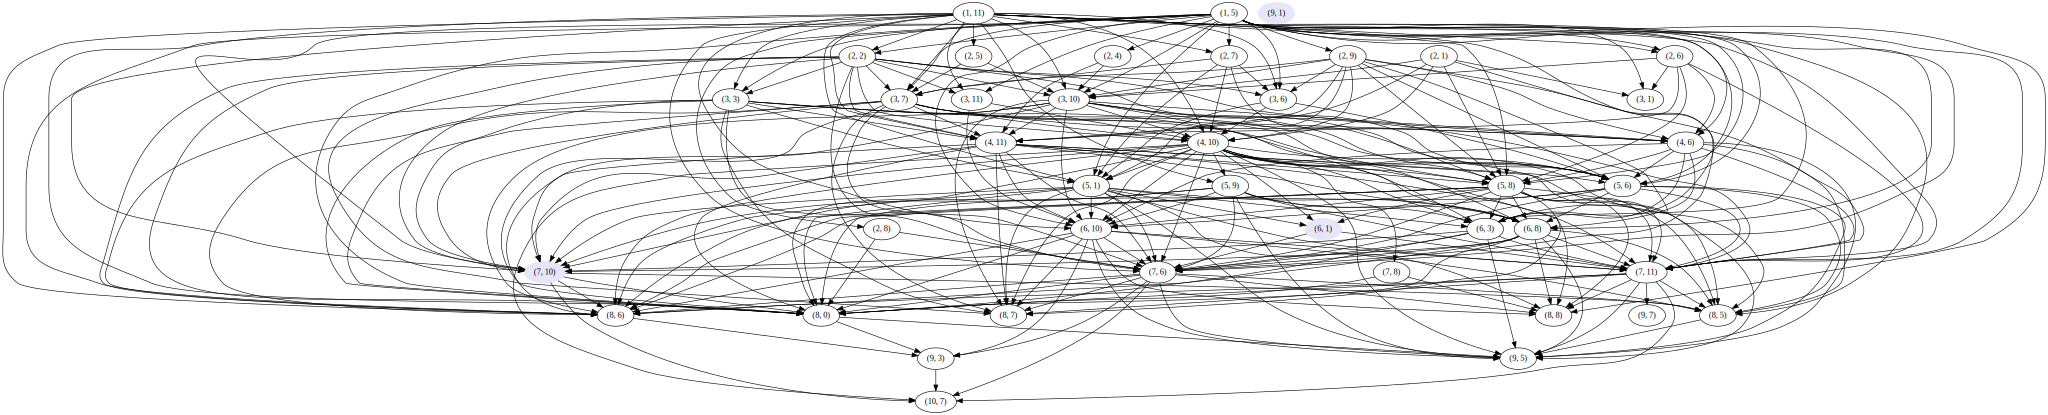

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=greater_than)

In [24]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## iter patch from 80% bf et 3

https://colab.research.google.com/drive/142sKzJR1Dnzn9rLcjTEw9EfdfAizpxDU#scrollTo=eAXQnzJyW28V&line=2&uniqifier=1

In [33]:
circuit = [(1, 5), (1, 11), (2, 1), (2, 2), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 1), (3, 3), (3, 6), (3, 7), (3, 10), (3, 11), (4, 6), (4, 10), (4, 11), (5, 1), (5, 6), (5, 8), (5, 9), (6, 1), (6, 3), (6, 8), (6, 10), (7, 6), (7, 8), (7, 10), (7, 11), (8, 0), (8, 5), (8, 6), (8, 7), (8, 8), (9, 1), (9, 3), (9, 5), (9, 7), (10, 7)]
topperc = 5

In [34]:
# %%capture
# results_dict = {}
# for head in circuit:
#     model.reset_hooks()
#     result = get_path_patch_head_to_heads(
#         receiver_heads = [head],
#         receiver_input = "v",
#         model = model,
#         patching_metric = ioi_metric_2
#     )
#     results_dict[head] = result

In [35]:
def thres_at_perc(results_dict, perc):
    # the top perc%
    all_values = []
    for result_tensor in results_dict.values():
        all_values.extend(result_tensor.cpu().numpy().flatten())
    sorted_values = sorted(all_values)

    ind_perc = (100 - perc)/100

    # Calculate the index for the top 10%
    index_10_percent = int(ind_perc * len(sorted_values))

    # Retrieve the value at that index
    value_at_10_percent = sorted_values[index_10_percent]
    return value_at_10_percent

In [36]:
%%capture
Ethres = thres_at_perc(results_dict, topperc)

head_adjList = {}
for head in circuit:
    result = results_dict[head]
    head_adjList[head] = edges_within_threshold(result, Ethres)

In [37]:
# only keep nodes that were part of original circuit
all_keys = set(head_adjList.keys())
# Iterate through the dictionary and filter the list values
for key, value in head_adjList.items():
    head_adjList[key] = [item for item in value if item in all_keys]

In [38]:
# Filter out nodes that don't have outgoing edges except for (9,1) and (10, 7)
# head_adjList = {node: neighbors for node, neighbors in head_adjList.items() if neighbors or node == (9,1) or node == (10,7)}

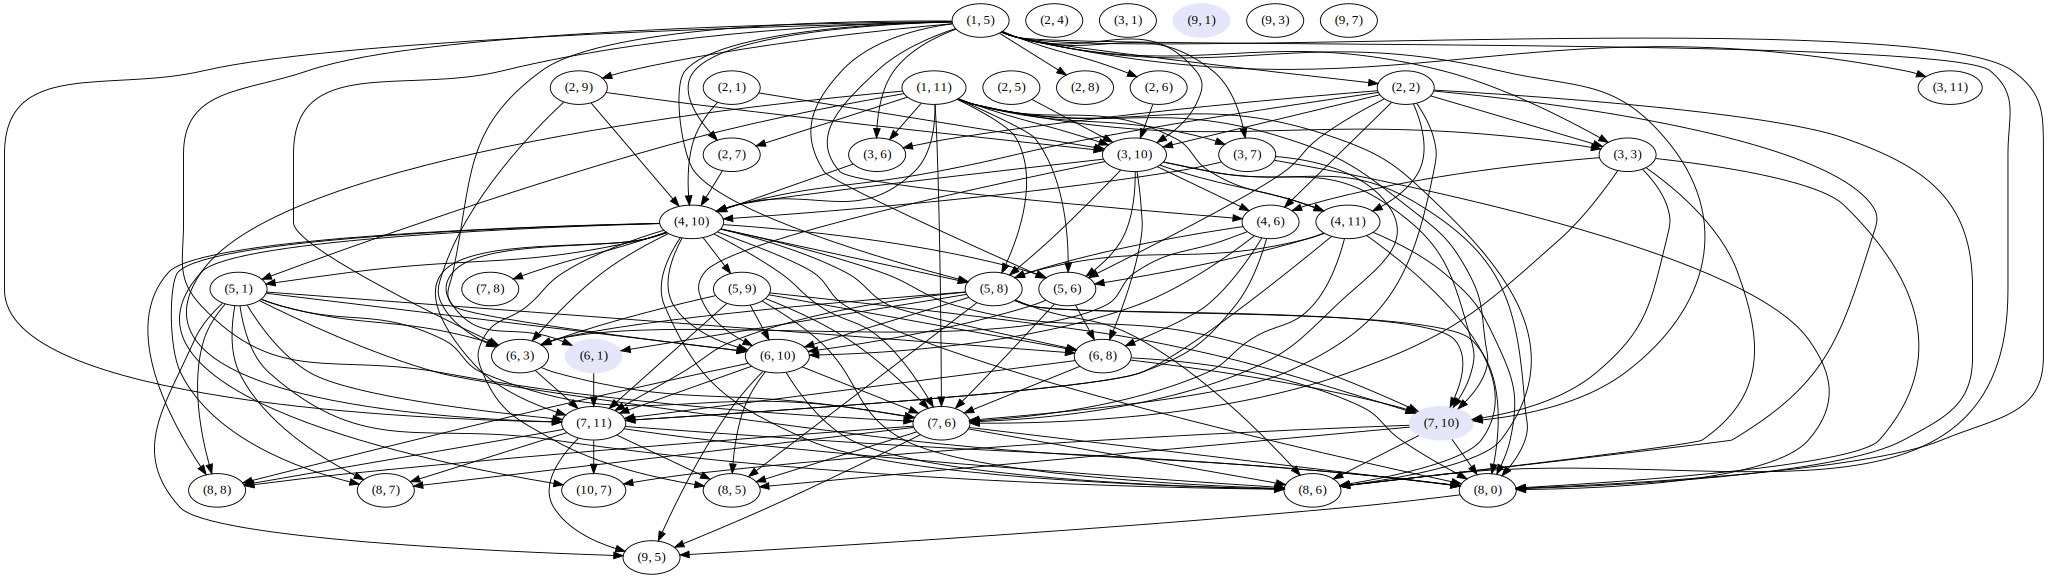

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
plot_graph_adjacency(head_adjList, filename="circuit_graph_top"+str(topperc)+"_perc", highlighted_nodes=greater_than)

In [40]:
import pickle

with open("results_dict.pkl", "wb") as file:
    pickle.dump(results_dict, file)
files.download("results_dict.pkl")

with open("head_adjList.pkl", "wb") as file:
    pickle.dump(head_adjList, file)
files.download("head_adjList.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>